### Detecting unique messages based on message reconstruction errors

In [271]:
#!pip install bs4
import pandas as pd
import numpy as np
import re
from numpy import save, load
import sqlalchemy as s
import unicodedata
import nltk
import string
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import SnowballStemmer
from sqlalchemy import create_engine
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
# nltk.download('all')


In [155]:
repo_id = 25827

# Fetch PR and issue messages of repo_id
join_SQL = s.sql.text("""
       select message.msg_id, msg_timestamp,  msg_text from augur_data.message
left outer join augur_data.pull_request_message_ref on message.msg_id = pull_request_message_ref.msg_id 
left outer join augur_data.pull_requests on pull_request_message_ref.pull_request_id = pull_requests.pull_request_id
where repo_id = :repo_id
UNION
select message.msg_id, msg_timestamp, msg_text from augur_data.message
left outer join augur_data.issue_message_ref on message.msg_id = issue_message_ref.msg_id 
left outer join augur_data.issues on issue_message_ref.issue_id = issues.issue_id
where repo_id = :repo_id""")

df_message = pd.read_sql_query(join_SQL, engine, params={'repo_id': repo_id})

In [156]:
df_message

,msg_id,msg_timestamp,msg_text
0,1880837,2020-03-11 17:21:43,> Isn't that the point of stabilising an IDE d...
1,2054646,2020-04-06 19:06:06,goodbye friend!
2,1883945,2020-02-28 18:46:02,"> No, at least not intentionally.\r\n\r\nCould..."
3,1883956,2020-03-10 10:54:39,@mauromol Thanks a lot for trying the latest C...
4,1933586,2018-12-05 06:07:18,Doesn't seem to be necessary. Extension pack l...
...,...,...,...
1861,1859406,2020-02-25 11:00:08,"Hey @sandorApati, hard to say remotely what ex..."
1862,1933712,2018-10-09 15:25:58,> I can confirm that the Spring-Data JPA Conte...
1863,1942947,2020-04-06 19:03:29,![image](https://user-images.githubusercontent...
1864,1922858,2020-04-01 16:27:00,Closing because of no response from @reszy wit...


In [157]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [275]:
## Preprocessing text

import nltk
import string
from nltk.tokenize import word_tokenize

punc=list(string.punctuation)
# Retaining to identify personal mentions, sentiment
punc.remove('!')
punc.remove('?')

stopword = nltk.corpus.stopwords.words('english')
snowBallStemmer = SnowballStemmer("english")

# Expanding contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# Removing stop words, punctuations, spaces, stemming...
def clean_text(text, remove_emojis):
    soup = BeautifulSoup(text)
    for tag in soup.find_all('strong'):
        tag.replaceWith('')
        text = soup.get_text()

    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = re.sub('[()){}]', ' ', text)
    text = re.sub('\<[^<>]*\>', '', text)
    text = re.sub('\`[^``]*\`', '', text)
    
    # emojis, ?, !, no/not are retained for sentiment analysis else removed
    if remove_emojis:
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        punc.extend(['!','?'])
        stopword.extend(['no','not'])
    # Removes personal mentions like @abc, and email addresses
    s = re.sub(r'\w*@\w*', ' ', text)   

    # Removes attached links
    s=' '.join(word for word in s.split(' ') if not word.startswith('http'))   

    # Separates joint words
    # Removes punctuation
    s = re.sub('[\.\-\_\\/&]', ' ', s)
    s = "".join([word.lower() for word in s if word not in punc])
    s = word_tokenize(s)

    # Stemming
    s = " ".join([snowBallStemmer.stem(word) for word in s if len(word)<=30])              

    # Tokenization
    s = re.sub('[0-9]+', '', s)
    s = re.sub('lgtm', 'look good', s)
    return s

# Normalize corpus
def normalize_corpus(text,contraction_expansion=True,clean=True,remove_emojis=True):
    if contraction_expansion:
        text = expand_contractions(text)
    if clean:
        text = clean_text(text,remove_emojis)
    return text

In [276]:
df_message['cleaned_msg_text'] = df_message['msg_text'].map(lambda x: normalize_corpus(x))

In [186]:
df_message

,msg_id,msg_timestamp,msg_text,cleaned_msg_text
0,1880837,2020-03-11 17:21:43,> Isn't that the point of stabilising an IDE d...,is not that the point of stabilis an ide despi...
1,2054646,2020-04-06 19:06:06,goodbye friend!,goodby friend
2,1883945,2020-02-28 18:46:02,"> No, at least not intentionally.\r\n\r\nCould...",no at least not intent could be that more of t...
3,1883956,2020-03-10 10:54:39,@mauromol Thanks a lot for trying the latest C...,thank a lot for tri the latest ci build and at...
4,1933586,2018-12-05 06:07:18,Doesn't seem to be necessary. Extension pack l...,doe not seem to be necessari extens pack list ...
...,...,...,...,...
1861,1859406,2020-02-25 11:00:08,"Hey @sandorApati, hard to say remotely what ex...",hey hard to say remot what exact is go wrong h...
1862,1933712,2018-10-09 15:25:58,> I can confirm that the Spring-Data JPA Conte...,i can confirm that the spring data jpa content...
1863,1942947,2020-04-06 19:03:29,![image](https://user-images.githubusercontent...,imag what do you mean not understand
1864,1922858,2020-04-01 16:27:00,Closing because of no response from @reszy wit...,close becaus of no respons from with more info...


In [187]:
df_message['msg_timestamp'] = [d.date() for d in df_message['msg_timestamp']]
df_message = df_message.sort_values(by='msg_timestamp')

In [198]:
df_past = df_message[df_message['msg_timestamp'].astype(str)< '2020-04-01']
df_present = df_message[df_message['msg_timestamp'].astype(str)>= '2020-04-01']

#### Making word embeddings using Doc2Vec

In [202]:
# Transformer which converts text corpus into document vectors.

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=300, learning_rate=0.01, epochs=50):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['cleaned_msg_text']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)
       
        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['cleaned_msg_text']).split())for index, row in df_x.iterrows()]))
    


In [203]:
# Fitting the data

doc2vec_tr = Doc2VecTransformer(vector_size=300)
df1 = pd.DataFrame(df_past['cleaned_msg_text'])
doc2vec_tr.fit(df1)
doc2vec_vectors = doc2vec_tr.transform(df1)


100%|██████████| 1300/1300 [00:00<00:00, 3268941.97it/s]


In [204]:
# Fitting the data

doc2vec_tr = Doc2VecTransformer(vector_size=300)
df1 = pd.DataFrame(df_present['cleaned_msg_text'])
doc2vec_tr.fit(df1)
doc2vec_vectors_test = doc2vec_tr.transform(df1)

100%|██████████| 566/566 [00:00<00:00, 1001255.19it/s]


#### Using auto-encoders

In [205]:
from sklearn.neural_network import MLPRegressor
# 600,150,600
auto_encoder = MLPRegressor(hidden_layer_sizes=(600,100,600))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(600, 100, 600), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [206]:
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

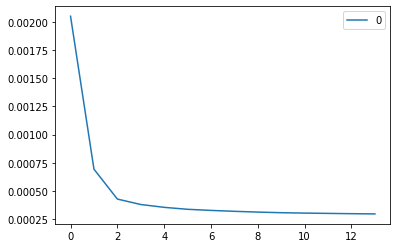

In [207]:
# Plotting the loss function
pd.DataFrame(auto_encoder.loss_curve_).plot()

In [208]:
from sklearn.externals import joblib

# Save to file in the current working directory
joblib_file = "{r_id}_uniq.pkl".format(r_id = repo_id)
joblib.dump(auto_encoder, joblib_file)

['25827_uniq.pkl']

In [209]:
# Load from file
model = joblib.load(joblib_file)

# Calculate the accuracy and predictions
predicted_vectors_test = model.predict(doc2vec_vectors_test)

In [258]:
# Determining the cosine similarity between predicted and Doc2Vec vectors, to get reconstruction errors

from scipy.spatial.distance import cosine

def key_cosine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(df_present)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((df_present['msg_id'].iloc[i], cosine_sim_val))

    return sorted(cosine_similarities, key=key_cosine_similarity, reverse=reverse)

def display_unique(sorted_cosine_similarities):
    i=0
    unique_message_list=[]
    cos_val = []
    index, cosine_sim_val = sorted_cosine_similarities[0]
    while cosine_sim_val<=-0.1:
        if cosine_sim_val not in cos_val:
            unique_message_list.append(index)
            cos_val.append(cosine_sim_val)
            print('Message id: ', index)  
            print('Cosine Sim Val :', cosine_sim_val)
        i+=1    
        index, cosine_sim_val = sorted_cosine_similarities[i]
        
    return unique_message_list

In [259]:
# Fetching message IDs with cosine similarity <= -0.09

sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors_test, predicted_vectors=predicted_vectors_test)
unique_message_list=display_unique(sorted_cosine_similarities)


Message id:  2078055
Cosine Sim Val : -0.16078783366683957
Message id:  2078100
Cosine Sim Val : -0.13244406223823568
Message id:  2078102
Cosine Sim Val : -0.11639643344889006
Message id:  2043996
Cosine Sim Val : -0.11535621128319651
Message id:  2115391
Cosine Sim Val : -0.10082256848112325


In [260]:
# Estimated count of unique messages
print('Unique messages count: '+str(len(unique_message_list)))

Unique messages count: 5


In [261]:
# List of anomalous messages
messages = df_present[df_present['msg_id'].isin(unique_message_list)]['msg_text'].tolist()
message_dates = df_present[df_present['msg_id'].isin(unique_message_list)]['msg_timestamp'].tolist()

In [265]:
messages[1]

'`return resolved;` might be missing here'

In [267]:
df = pd.DataFrame(list(zip(message_dates, messages)), 
               columns =['date', 'message']) 

In [268]:
anomalies = pd.DataFrame(df.groupby(['date'])['message'].count())
anomalies.columns=['count']

In [269]:
idx = pd.date_range(anomalies.index.min(), anomalies.index.max())
anomalies = anomalies.reindex(idx, fill_value=0)

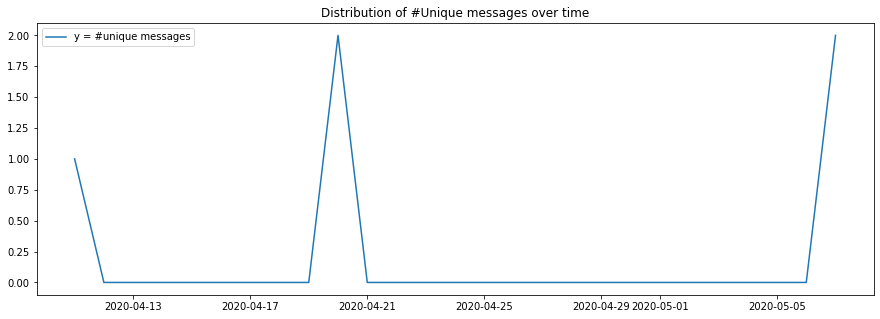

In [272]:
plt.figure(figsize=(15,5))
plt.title("Distribution of #Unique messages over time")
plt.plot(anomalies.index,anomalies['count'])
plt.legend(['y = #unique messages'], loc='upper left')